In [4]:
!pip install gensim

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.base import BaseEstimator, TransformerMixin

from transformers import BertTokenizer, BertModel
import torch


import warnings
warnings.filterwarnings('ignore')

In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("naserabdullahalam/phishing-email-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/phishing-email-dataset


In [15]:
import os
import pandas as pd

# Load all CSVs from directory
input_paths = []
for dirname, _, filenames in os.walk('/kaggle/input/phishing-email-dataset'):
    for filename in filenames:
        if filename.endswith('.csv'):
            file_path = os.path.join(dirname, filename)
            input_paths.append(file_path)

# Load and merge all CSVs
dfs = []
for path in input_paths:
    try:
        df_part = pd.read_csv(path)
        if 'body' in df_part.columns and 'label' in df_part.columns:
            dfs.append(df_part[['body', 'label']])
            print(f"Loaded: {path}")
    except Exception as e:
        print(f"Failed to load {path}: {e}")

df = pd.concat(dfs, ignore_index=True)
df.head()



Loaded: /kaggle/input/phishing-email-dataset/SpamAssasin.csv
Loaded: /kaggle/input/phishing-email-dataset/Nazario.csv
Loaded: /kaggle/input/phishing-email-dataset/Nigerian_Fraud.csv
Loaded: /kaggle/input/phishing-email-dataset/CEAS_08.csv
Loaded: /kaggle/input/phishing-email-dataset/Enron.csv
Loaded: /kaggle/input/phishing-email-dataset/Ling.csv


,body,label
0,"Date: Wed, 21 Aug 2002 10:54:46 -0500 ...",0
1,"Martin A posted:\nTassos Papadopoulos, the Gre...",0
2,Man Threatens Explosion In Moscow \n\nThursday...,0
3,Klez: The Virus That Won't Die\n \nAlready the...,0
4,"> in adding cream to spaghetti carbonara, whi...",0


CLEAN DATA

In [16]:
df = df.dropna(subset=['body'])
df['clean_text'] = df['body'].str.lower().str.replace(r'[^a-z\s]', '', regex=True)
df = df[['clean_text', 'label']].dropna().reset_index(drop=True)
df.head()

,clean_text,label
0,date wed aug from chris ...,0
1,martin a posted\ntassos papadopoulos the greek...,0
2,man threatens explosion in moscow \n\nthursday...,0
3,klez the virus that wont die\n \nalready the m...,0
4,in adding cream to spaghetti carbonara which...,0


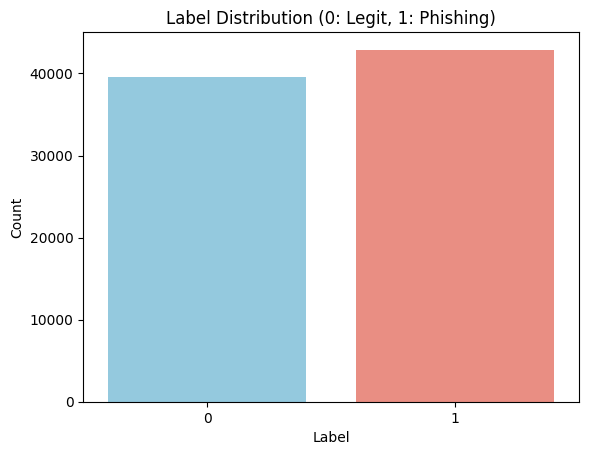

In [17]:
sns.countplot(x='label', data=df, palette={'0': 'skyblue', '1': 'salmon'})
plt.title("Label Distribution (0: Legit, 1: Phishing)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()



Feature Extraction Function

In [18]:
class MeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model): self.model, self.dim = model, model.vector_size
    def fit(self, X, y=None): return self
    def transform(self, X):
        return np.array([np.mean([self.model.wv[w] for w in toks if w in self.model.wv] or [np.zeros(self.dim)], axis=0) for toks in X])

# BERT setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()
def bert_embed(texts):
    with torch.no_grad():
        inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
        out = bert_model(**inputs)
        return out.last_hidden_state[:,0,:].numpy()

def extract_features(X, method, w2v_model=None):
    if method=='tfidf':
        vec = TfidfVectorizer(max_features=5000, stop_words='english')
        return vec.fit_transform(X), vec
    if method=='bow':
        vec = CountVectorizer(max_features=5000, stop_words='english')
        return vec.fit_transform(X), vec
    if method=='word2vec':
        tokens = X.apply(simple_preprocess)
        w2v = Word2Vec(tokens, vector_size=100, window=5, min_count=1, workers=4, epochs=10)
        vec = MeanEmbeddingVectorizer(w2v)
        return vec.fit_transform(tokens), vec
    if method=='bert':
        emb = bert_embed(X.tolist())
        return emb, None
    raise ValueError


In [19]:
X_tfidf, vec_tfidf = extract_features(df['clean_text'], 'tfidf')
print("TF-IDF shape:", X_tfidf.shape)

X_bow, vec_bow = extract_features(df['clean_text'], 'bow')
print("BoW shape:", X_bow.shape)

#X_w2v, vec_w2v = extract_features(df['clean_text'], 'word2vec')
#print("Word2Vec shape:", X_w2v.shape)

#X_bert, _ = extract_features(df['clean_text'][:100], 'bert')  # Use a smaller subset to avoid OOM
#print("BERT shape:", X_bert.shape)


TF-IDF shape: (82485, 5000)
BoW shape: (82485, 5000)


Word Cloud for Phishing vs. Legitimate Emails

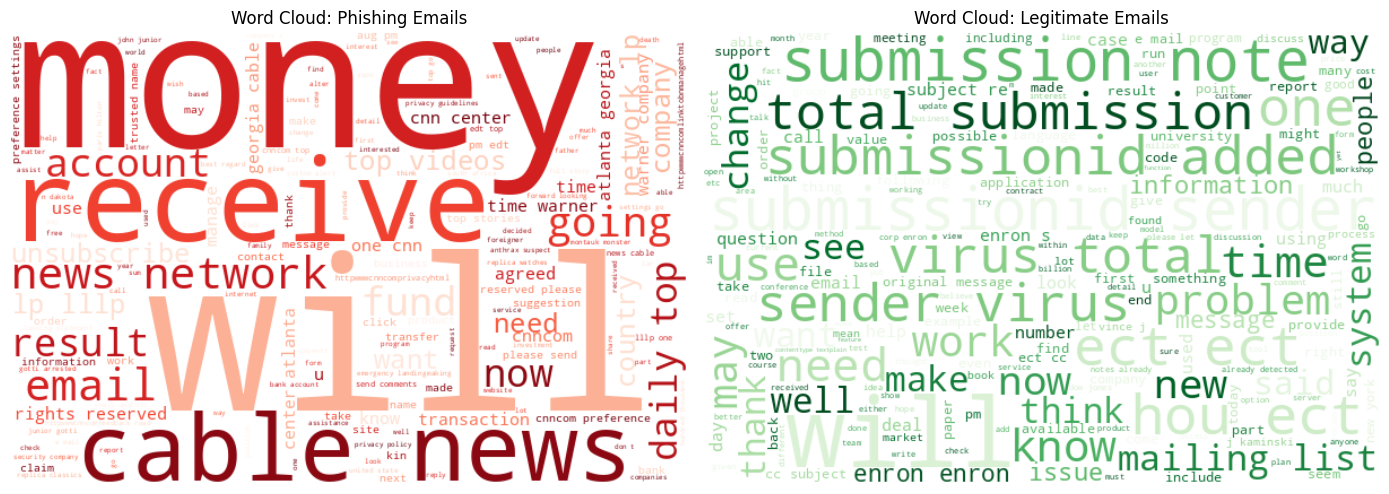

In [12]:
from wordcloud import WordCloud
from PIL import Image

# Separate phishing and legit emails
phishing_text = " ".join(df[df['label'] == 1]['clean_text'])
legit_text = " ".join(df[df['label'] == 0]['clean_text'])

# Generate Word Clouds
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
wc1 = WordCloud(width=600, height=400, background_color='white', colormap='Reds').generate(phishing_text)
plt.imshow(wc1, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud: Phishing Emails")

plt.subplot(1, 2, 2)
wc2 = WordCloud(width=600, height=400, background_color='white', colormap='Greens').generate(legit_text)
plt.imshow(wc2, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud: Legitimate Emails")

plt.tight_layout()
plt.show()


PCA Visualization of Embeddings

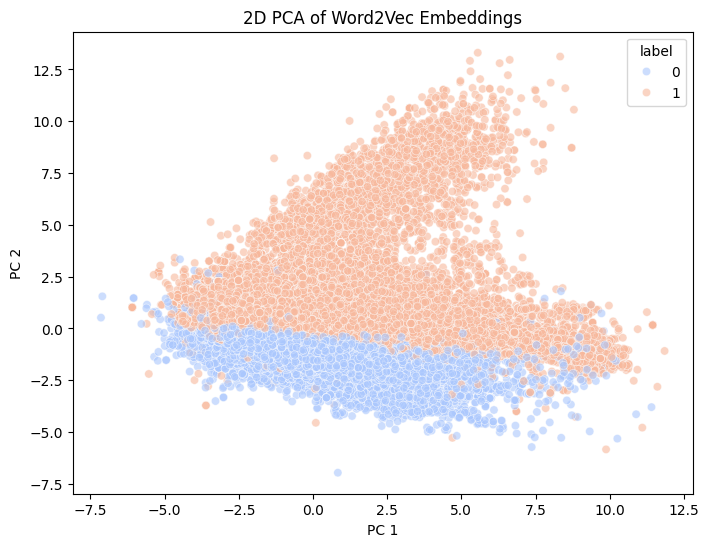

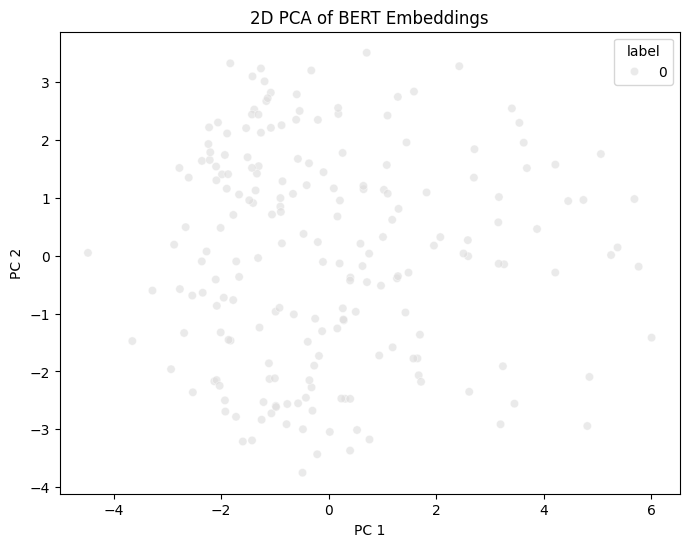

In [13]:
from sklearn.decomposition import PCA

def plot_embeddings(X, y, title):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(X)
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=y, palette='coolwarm', alpha=0.6)
    plt.title(f'2D PCA of {title} Embeddings')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.show()

# Word2Vec Example
X_w2v, _ = extract_features(df['clean_text'], 'word2vec')
plot_embeddings(X_w2v, df['label'], 'Word2Vec')

# BERT Example (on subset for speed)
X_bert, _ = extract_features(df['clean_text'][:200], 'bert')
plot_embeddings(X_bert, df['label'][:200], 'BERT')


Random Forest Classifier

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_random_forest(X, y, vec_name='tfidf', k=5, max_depth=10):
    model = RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        max_depth=max_depth

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    accs, precs, recalls, f1s = [], [], [], []
    all_preds, all_true = [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)

        accs.append(accuracy_score(y_val, preds))
        precs.append(precision_score(y_val, preds))
        recalls.append(recall_score(y_val, preds))
        f1s.append(f1_score(y_val, preds))

        all_preds.extend(preds)
        all_true.extend(y_val)

        print(f"Fold {fold}: Acc={accs[-1]:.4f}, Prec={precs[-1]:.4f}, Recall={recalls[-1]:.4f}, F1={f1s[-1]:.4f}")

    # Summary Table
    avg_metrics = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Score': [np.mean(accs), np.mean(precs), np.mean(recalls), np.mean(f1s)]
    })
    print(f"\n=== Random Forest (max_depth={max_depth}) - Average Evaluation Metrics ===")
    print(avg_metrics.to_string(index=False))

    # Confusion Matrix
    cm = confusion_matrix(all_true, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Legit', 'Phish'], yticklabels=['Legit', 'Phish'])
    plt.title(f"Random Forest Confusion Matrix - {vec_name.upper()}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Bar Plot
    plt.figure(figsize=(6, 4))
    sns.barplot(x=avg_metrics['Metric'], y=avg_metrics['Score'], palette='Greens')
    plt.title(f"Random Forest Average Metrics - {vec_name.upper()}")
    plt.ylim(0.5, 1.0)
    plt.tight_layout()
    plt.show()





In [44]:
y = df['label']


Fold 1: Acc=0.9728, Prec=0.9661, Recall=0.9823, F1=0.9741
Fold 2: Acc=0.9700, Prec=0.9619, Recall=0.9811, F1=0.9714
Fold 3: Acc=0.9694, Prec=0.9603, Recall=0.9818, F1=0.9709
Fold 4: Acc=0.9719, Prec=0.9639, Recall=0.9827, F1=0.9732
Fold 5: Acc=0.9707, Prec=0.9632, Recall=0.9812, F1=0.9721

=== Random Forest (max_depth=70) - Average Evaluation Metrics ===
   Metric    Score
 Accuracy 0.970977
Precision 0.963069
   Recall 0.981837
 F1 Score 0.972362


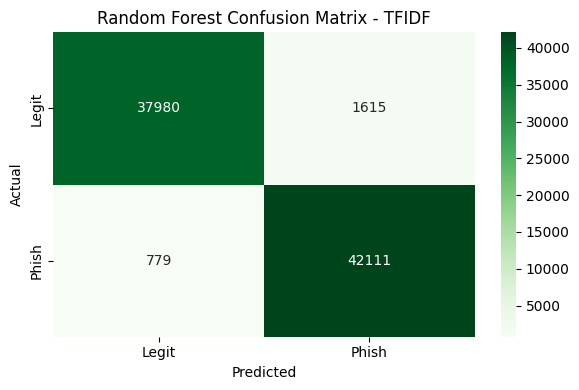

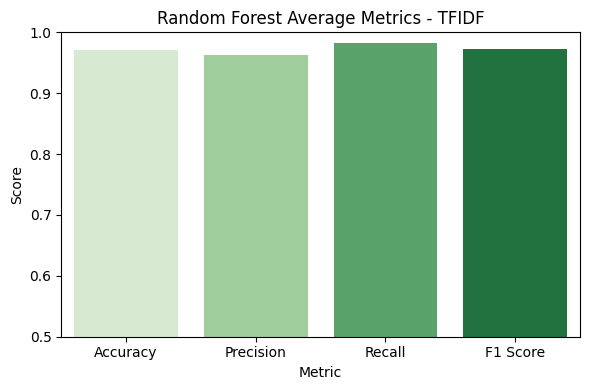

Fold 1: Acc=0.9734, Prec=0.9648, Recall=0.9848, F1=0.9747
Fold 2: Acc=0.9712, Prec=0.9628, Recall=0.9826, F1=0.9726
Fold 3: Acc=0.9703, Prec=0.9631, Recall=0.9804, F1=0.9717
Fold 4: Acc=0.9717, Prec=0.9626, Recall=0.9838, F1=0.9731
Fold 5: Acc=0.9704, Prec=0.9619, Recall=0.9820, F1=0.9719

=== Random Forest (max_depth=70) - Average Evaluation Metrics ===
   Metric    Score
 Accuracy 0.971413
Precision 0.963033
   Recall 0.982747
 F1 Score 0.972789


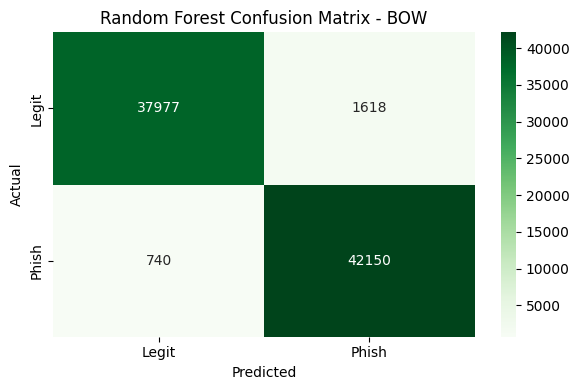

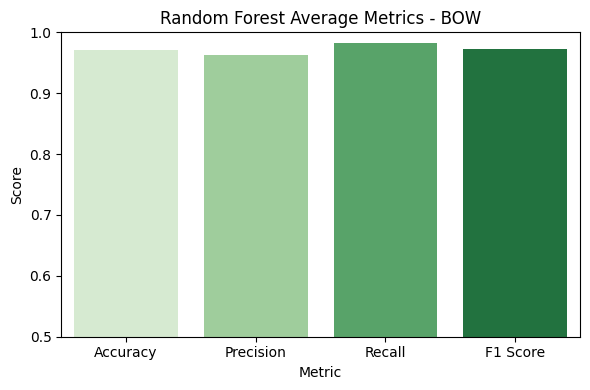

In [49]:
evaluate_random_forest(X_tfidf, df['label'], vec_name='tfidf', max_depth=70)
evaluate_random_forest(X_bow, df['label'], vec_name='bow', max_depth=70)


Support Vector Machine

In [25]:
from sklearn.svm import LinearSVC


In [26]:
def evaluate_svm(X, y, vec_name, k=5):
    svm = LinearSVC(class_weight='balanced', random_state=42, max_iter=10000)
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    accs, precs, recalls, f1s = [], [], [], []
    all_preds, all_true = [], []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        svm.fit(X_train, y_train)
        preds = svm.predict(X_val)

        accs.append(accuracy_score(y_val, preds))
        precs.append(precision_score(y_val, preds))
        recalls.append(recall_score(y_val, preds))
        f1s.append(f1_score(y_val, preds))

        all_preds.extend(preds)
        all_true.extend(y_val)

        print(f"Fold {fold}: Acc={accs[-1]:.4f}, Prec={precs[-1]:.4f}, Recall={recalls[-1]:.4f}, F1={f1s[-1]:.4f}")

    # Summary Table
    print("\n=== Average Evaluation Metrics ===")
    avg_metrics = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Score': [np.mean(accs), np.mean(precs), np.mean(recalls), np.mean(f1s)]
    })
    print(avg_metrics.to_string(index=False))

    # Confusion Matrix
    cm = confusion_matrix(all_true, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Legit (0)', 'Phishing (1)'], yticklabels=['Legit (0)', 'Phishing (1)'])
    plt.title(f"SVM Confusion Matrix - {vec_name.upper()}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Bar Plot of Metrics
    plt.figure(figsize=(6, 4))
    sns.barplot(x=avg_metrics['Metric'], y=avg_metrics['Score'], palette='magma')
    plt.title(f"SVM Average Metrics - {vec_name.upper()}")
    plt.ylim(0.5, 1.0)
    plt.tight_layout()
    plt.show()


Fold 1: Acc=0.9811, Prec=0.9803, Recall=0.9832, F1=0.9818
Fold 2: Acc=0.9811, Prec=0.9782, Recall=0.9860, F1=0.9821
Fold 3: Acc=0.9805, Prec=0.9776, Recall=0.9851, F1=0.9814
Fold 4: Acc=0.9793, Prec=0.9747, Recall=0.9857, F1=0.9802
Fold 5: Acc=0.9787, Prec=0.9751, Recall=0.9843, F1=0.9796

=== Average Evaluation Metrics ===
   Metric    Score
 Accuracy 0.980166
Precision 0.977175
   Recall 0.984864
 F1 Score 0.981003


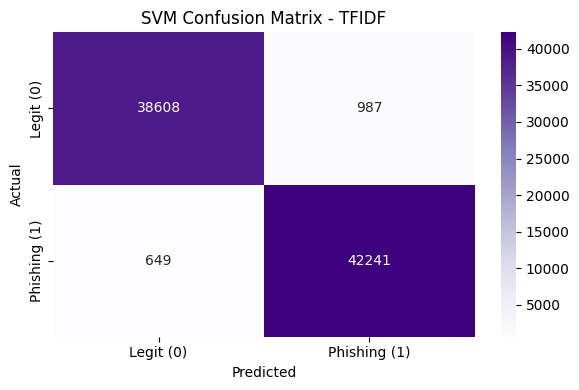

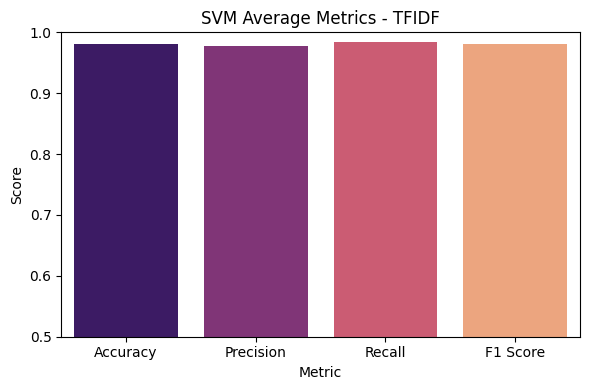

Fold 1: Acc=0.9762, Prec=0.9741, Recall=0.9800, F1=0.9770
Fold 2: Acc=0.9747, Prec=0.9721, Recall=0.9798, F1=0.9760
Fold 3: Acc=0.9762, Prec=0.9724, Recall=0.9823, F1=0.9773
Fold 4: Acc=0.9744, Prec=0.9692, Recall=0.9819, F1=0.9755
Fold 5: Acc=0.9738, Prec=0.9693, Recall=0.9805, F1=0.9749

=== Average Evaluation Metrics ===
   Metric    Score
 Accuracy 0.975074
Precision 0.971421
   Recall 0.980927
 F1 Score 0.976150


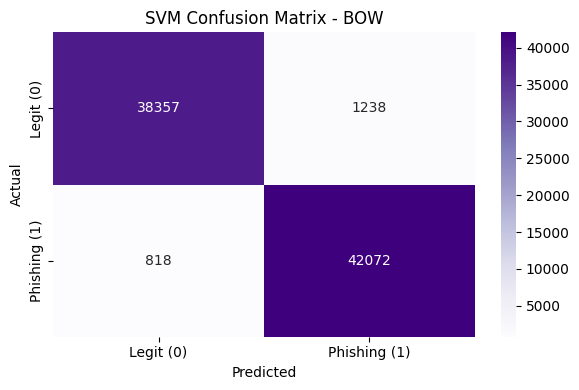

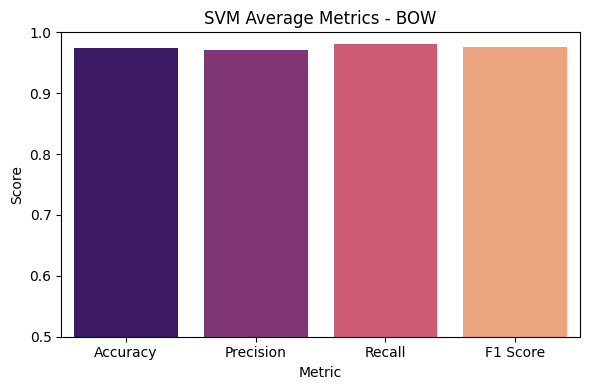

In [27]:
evaluate_svm(X_tfidf.toarray(), y, 'tfidf')
evaluate_svm(X_bow.toarray(), y, 'bow')


Naive bayes

In [42]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def evaluate_naive_bayes(X, y, vec_name='tfidf', k=5):
    model = MultinomialNB()
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    accs, precs, recalls, f1s = [], [], [], []
    all_preds, all_true = [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)

        accs.append(accuracy_score(y_val, preds))
        precs.append(precision_score(y_val, preds))
        recalls.append(recall_score(y_val, preds))
        f1s.append(f1_score(y_val, preds))

        all_preds.extend(preds)
        all_true.extend(y_val)

        print(f"Fold {fold}: Acc={accs[-1]:.4f}, Prec={precs[-1]:.4f}, Recall={recalls[-1]:.4f}, F1={f1s[-1]:.4f}")

    # Summary Table
    avg_metrics = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Score': [np.mean(accs), np.mean(precs), np.mean(recalls), np.mean(f1s)]
    })
    print("\n=== Naive Bayes - Average Evaluation Metrics ===")
    print(avg_metrics.to_string(index=False))

    # Confusion Matrix
    cm = confusion_matrix(all_true, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Legit', 'Phish'], yticklabels=['Legit', 'Phish'])
    plt.title(f"Naive Bayes Confusion Matrix - {vec_name.upper()}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Bar Plot
    plt.figure(figsize=(6, 4))
    sns.barplot(x=avg_metrics['Metric'], y=avg_metrics['Score'], palette='Oranges_d')
    plt.title(f"Naive Bayes Average Metrics - {vec_name.upper()}")
    plt.ylim(0.5, 1.0)
    plt.tight_layout()
    plt.show()


Fold 1: Acc=0.9521, Prec=0.9758, Recall=0.9309, F1=0.9528
Fold 2: Acc=0.9538, Prec=0.9783, Recall=0.9318, F1=0.9545
Fold 3: Acc=0.9512, Prec=0.9775, Recall=0.9275, F1=0.9518
Fold 4: Acc=0.9533, Prec=0.9776, Recall=0.9315, F1=0.9540
Fold 5: Acc=0.9524, Prec=0.9761, Recall=0.9313, F1=0.9532

=== Naive Bayes - Average Evaluation Metrics ===
   Metric    Score
 Accuracy 0.952549
Precision 0.977063
   Recall 0.930590
 F1 Score 0.953260


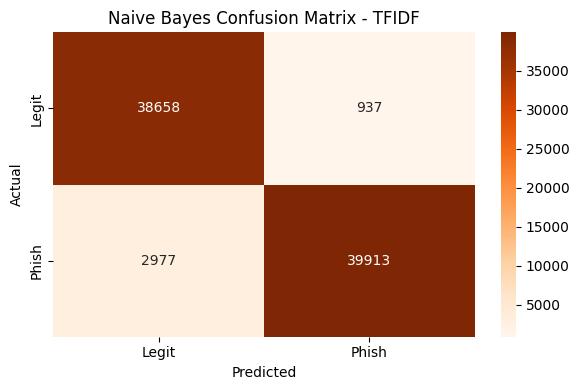

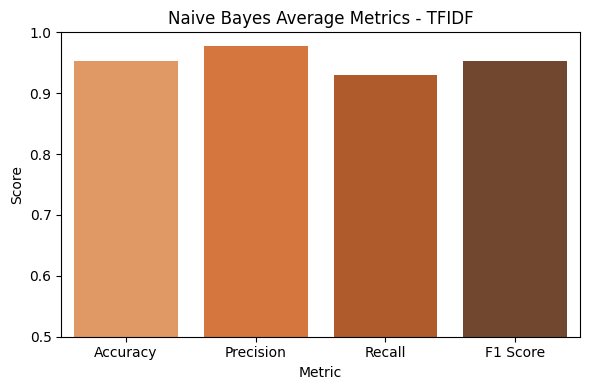

Fold 1: Acc=0.9402, Prec=0.9719, Recall=0.9113, F1=0.9406
Fold 2: Acc=0.9413, Prec=0.9724, Recall=0.9130, F1=0.9418
Fold 3: Acc=0.9409, Prec=0.9750, Recall=0.9097, F1=0.9412
Fold 4: Acc=0.9408, Prec=0.9744, Recall=0.9101, F1=0.9412
Fold 5: Acc=0.9411, Prec=0.9735, Recall=0.9115, F1=0.9415

=== Naive Bayes - Average Evaluation Metrics ===
   Metric    Score
 Accuracy 0.940862
Precision 0.973448
   Recall 0.911121
 F1 Score 0.941253


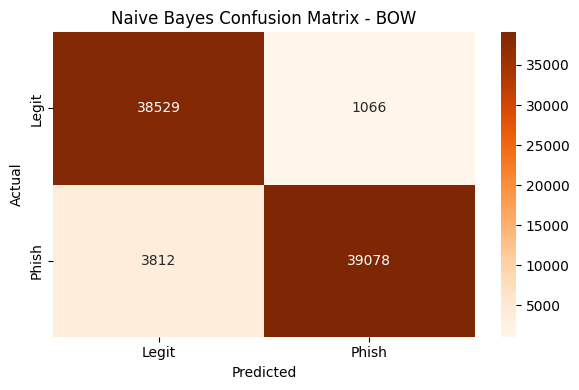

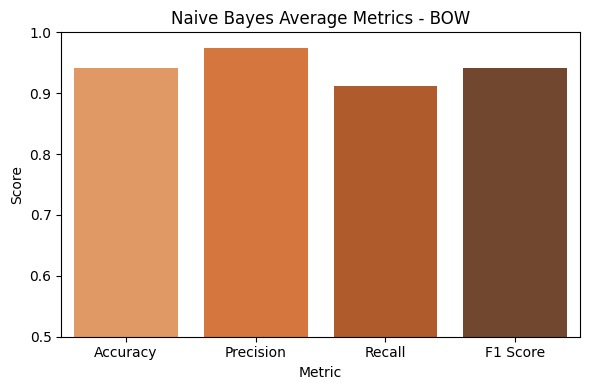

In [40]:
# For TF-IDF
evaluate_naive_bayes(X_tfidf, y, vec_name='tfidf')

# For BoW
evaluate_naive_bayes(X_bow, y, vec_name='bow')


Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

def evaluate_logistic_regression(X, y, vec_name='tfidf', k=5):
    model = LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear', random_state=42)
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    accs, precs, recalls, f1s = [], [], [], []
    all_preds, all_true = [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)

        accs.append(accuracy_score(y_val, preds))
        precs.append(precision_score(y_val, preds))
        recalls.append(recall_score(y_val, preds))
        f1s.append(f1_score(y_val, preds))

        all_preds.extend(preds)
        all_true.extend(y_val)

        print(f"Fold {fold}: Acc={accs[-1]:.4f}, Prec={precs[-1]:.4f}, Recall={recalls[-1]:.4f}, F1={f1s[-1]:.4f}")

    # Summary
    avg_metrics = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Score': [np.mean(accs), np.mean(precs), np.mean(recalls), np.mean(f1s)]
    })
    print("\n=== Logistic Regression - Average Evaluation Metrics ===")
    print(avg_metrics.to_string(index=False))

    # Confusion Matrix
    cm = confusion_matrix(all_true, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Phish'], yticklabels=['Legit', 'Phish'])
    plt.title(f"Logistic Regression Confusion Matrix - {vec_name.upper()}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Bar Plot
    plt.figure(figsize=(6, 4))
    sns.barplot(x=avg_metrics['Metric'], y=avg_metrics['Score'], palette='Blues_d')
    plt.title(f"Logistic Regression Average Metrics - {vec_name.upper()}")
    plt.ylim(0.5, 1.0)
    plt.tight_layout()
    plt.show()


Fold 1: Acc=0.9777, Prec=0.9743, Recall=0.9830, F1=0.9786
Fold 2: Acc=0.9779, Prec=0.9758, Recall=0.9819, F1=0.9788
Fold 3: Acc=0.9768, Prec=0.9739, Recall=0.9818, F1=0.9778
Fold 4: Acc=0.9783, Prec=0.9753, Recall=0.9832, F1=0.9792
Fold 5: Acc=0.9775, Prec=0.9725, Recall=0.9845, F1=0.9784

=== Logistic Regression - Average Evaluation Metrics ===
   Metric    Score
 Accuracy 0.977644
Precision 0.974347
   Recall 0.982886
 F1 Score 0.978597


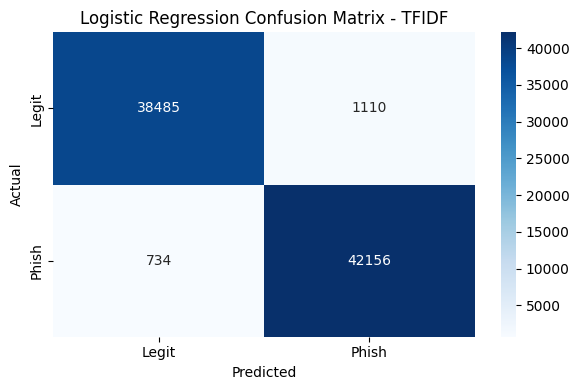

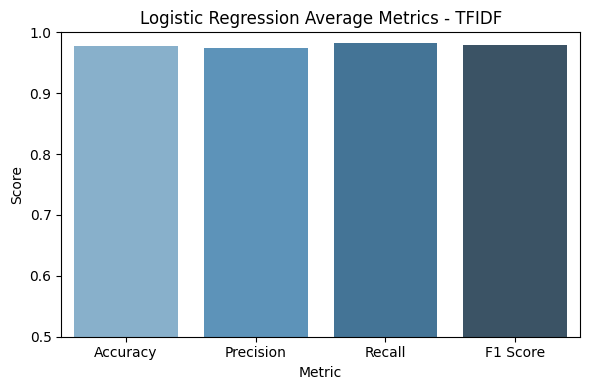

Fold 1: Acc=0.9790, Prec=0.9744, Recall=0.9854, F1=0.9799
Fold 2: Acc=0.9790, Prec=0.9739, Recall=0.9860, F1=0.9799
Fold 3: Acc=0.9763, Prec=0.9697, Recall=0.9852, F1=0.9774
Fold 4: Acc=0.9787, Prec=0.9732, Recall=0.9861, F1=0.9796
Fold 5: Acc=0.9764, Prec=0.9720, Recall=0.9830, F1=0.9775

=== Logistic Regression - Average Evaluation Metrics ===
   Metric    Score
 Accuracy 0.977863
Precision 0.972632
   Recall 0.985148
 F1 Score 0.978849


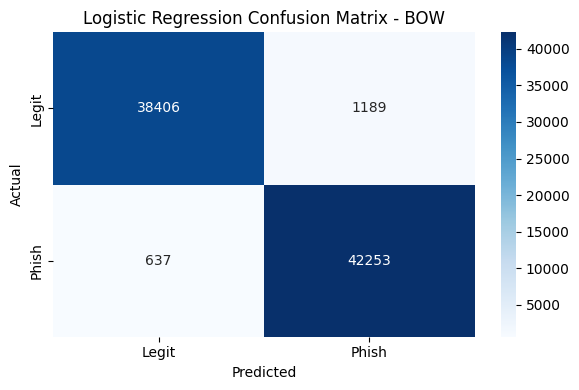

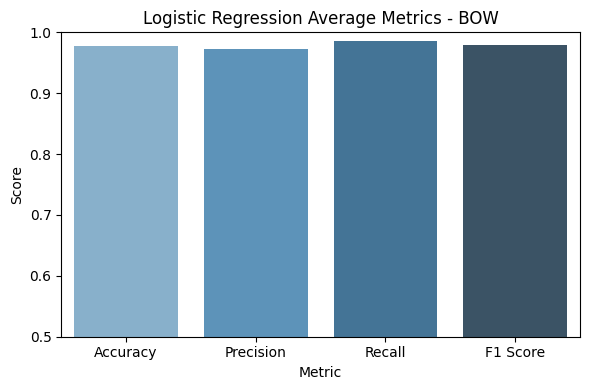

In [33]:
# Run for TF-IDF
evaluate_logistic_regression(X_tfidf, y, vec_name='tfidf')

# Run for BoW
evaluate_logistic_regression(X_bow, y, vec_name='bow')